Copyright 2019 The Google Research Authors.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Corrupted Sample Discovery & Robust Learning using DVRL

 * Jinsung Yoon, Sercan O Arik, Tomas Pfister, "Data Valuation using Reinforcement Learning", arXiv preprint arXiv:1909.11671 (2019) - https://arxiv.org/abs/1909.11671

This notebook describes the user-guide of corrupted sample discovery and robust learning applications using "Data Valuation using Reinforcement Learning (DVRL)". 

There are some scenarios where training samples may contain corrupted samples, e.g. due to cheap label collection methods. An automated corrupted sample discovery method would be highly beneficial for distinguishing samples with clean vs. noisy labels. Data valuation can be used in this setting by having a small clean validation set to assign low data values to the potential samples with noisy labels. With an optimal data value estimator, all noisy labels would get the lowest data values. 

DVRL can also reliably learn with noisy data in an end-to-end way. Ideally, noisy samples should get low data values as DVRL converges and a high performance model can be returned.

You need:

**Training set** (low-quality data (e.g. noisy data)) / **Validation set** (high-quality data (e.g. clean data)) / **Testing set** (high-quality data (e.g. clean data)) 
 * If there is no explicit validation set, you can split a small portion of testing set as the validation set. 
 * Note that training set does not have to be low quality for DVRL; however, in this notebook, we use a low quality training set for a more clear demonstration as the samples are easier to distinguish in terms of their value.
 * If you have your own training / validation / testing datasets, you can put them under './repo/data_files/' directory with 'train.csv', 'valid.csv', 'test.csv' names.
 * In this notebook, we use adult income dataset (https://archive.ics.uci.edu/ml/datasets/Adult) as an example.

##  Prerequisite

 * Download lightgbm package.
 * Clone https://github.com/google-research/google-research.git to the current directory.

In [ ]:
# Uses pip3 to install necessary package (lightgbm)
!pip3 install lightgbm

# Resets the IPython kernel to import the installed package.
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)  

In [2]:
import os
from git import Repo

# Current working directory
repo_dir = os.getcwd() + '/repo'

if not os.path.exists(repo_dir):
    os.makedirs(repo_dir)

# Clones github repository
if not os.listdir(repo_dir):
    git_url = "https://github.com/google-research/google-research.git"
    Repo.clone_from(git_url, repo_dir)

## Necessary packages and functions call

 * load_tabular_data: Data loader for tabular datasets.
 * data_preprocess: Data extraction and normalization.
 * dvrl_classification: Data valuation function for classification problem.
 * metrics: Evaluation metrics of the quality of data valuation in various metrics.

In [3]:
import numpy as np
import tensorflow as tf
from sklearn import linear_model
import lightgbm

# Sets current directory
os.chdir(repo_dir)

from dvrl.data_loading import load_tabular_data, preprocess_data
from dvrl import dvrl
from dvrl.dvrl_metrics import discover_corrupted_sample, remove_high_low, learn_with_dvrl

## Data loading & Sample corruption

 * Create training dataset, validation and testing datasets, and save as train.csv, valid.csv, test.csv under './repo/data_files/' directory.
 * In this notebook, we corrupt a certain portion of samples in training set to create "artificially" low-quality data.
 * If you have your own train.csv (low-quality data), valid.csv (ideally high-quality data), test.csv (ideally similar to validation distribution), you can skip this cell and just save those files to './repo/data_files/' directory.

In [4]:
# Data name: 'adult' in this notebook
data_name = 'adult'

# The number of training and validation samples
dict_no = dict()
dict_no['train'] = 1000
dict_no['valid'] = 400

# Label noise ratio
noise_rate = 0.2

# Loads data and corrupts labels
noise_idx = load_tabular_data(data_name, dict_no, noise_rate)
# noise_idx: ground truth noisy sample indices

print('Finished data loading.')

Finished data loading.


## Data preprocessing

 * Extract features and labels from train.csv, valid.csv, test.csv in './repo/data_files/' directory.
 * Normalize the features of training, validation, and testing sets.

In [5]:
# Normalization methods: 'minmax' or 'standard'
normalization = 'minmax' 

# Extracts features and labels. Then, normalizes features.
x_train, y_train, x_valid, y_valid, x_test, y_test, _ = \
preprocess_data(normalization, 'train.csv', 'valid.csv', 'test.csv')

print('Finished data preprocess.')

Finished data preprocess.


/usr/local/google/home/jinsungyoon/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


## Run DVRL

1. **Input**: 

 * data valuator network parameters: Set network parameters of data valuator.
 * pred_model: The predictor model that maps output from the input. Any machine learning model (e.g. a neural network or ensemble decision tree) can be used as the predictor model, as long as it has fit, and predict (for regression)/predict_proba (for classification) as its subfunctions. Fit can be implemented using multiple backpropagation iterations.
 
 
2. **Output**:
 * data_valuator: Function that uses training set as inputs to estimate data values.
 * dvrl_predictor: Function that predicts labels of the testing samples.
 * dve_out: Estimated data values for all training samples.

In [6]:
# Resets the graph
tf.reset_default_graph()

# Network parameters
parameters = dict()
parameters['hidden_dim'] = 100
parameters['comb_dim'] = 10
parameters['iterations'] = 2000
parameters['activation'] = tf.nn.relu
parameters['layer_number'] = 5
parameters['batch_size'] = 2000
parameters['learning_rate'] = 0.01

# Sets checkpoint file name
checkpoint_file_name = './tmp/model.ckpt'

# Defines predictive model
pred_model = linear_model.LogisticRegression(solver='lbfgs')
problem = 'classification'

# Flags for using stochastic gradient descent / pre-trained model
flags = {'sgd': False, 'pretrain': False}

# Initalizes DVRL
dvrl_class = dvrl.Dvrl(x_train, y_train, x_valid, y_valid, 
                       problem, pred_model, parameters, checkpoint_file_name, flags)

# Trains DVRL
dvrl_class.train_dvrl('auc')

print('Finished dvrl training.')

# Estimates data values
dve_out = dvrl_class.data_valuator(x_train, y_train)

# Predicts with DVRL
y_test_hat = dvrl_class.dvrl_predictor(x_test)

print('Finished data valuation.')


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.


100%|██████████| 2000/2000 [02:12<00:00, 15.10it/s]


Finished dvrl training.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./tmp/model.ckpt
Finished data valuation.


## Evaluations

 * In this notebook, we use LightGBM as the predictive model in DVRL (but we can also replace it with another method for evaluation purposes.
 * Here, we use average accuracy as the performance metric (we can also replace with other metrics like AUC, see metrics.py).

### 1. Robust learning

DVRL learns robustly although the training data contains low quality/noisy samples, using the guidance from the high quality/clean validation data via reinforcement learning.
 * Train predictive model with weighted optimization using estimated data values by DVRL as the weights.

In [7]:
# Defines evaluation model
eval_model = lightgbm.LGBMClassifier()

# Robust learning (DVRL-weighted learning)
robust_perf = learn_with_dvrl(dve_out, eval_model, 
                              x_train, y_train, x_valid, y_valid, x_test, y_test, 'accuracy')

print('DVRL-weighted learning performance: ' + str(np.round(robust_perf, 4)))

DVRL-weighted learning performance: 0.8272


### 2. Removing high/low valued samples

Removing low value samples from the training dataset can improve the predictor model performance, especially in the cases where the training dataset contains corrupted samples. On the other
hand, removing high value samples, especially if the dataset is small, would decrease the performance significantly. Overall, the performance after removing high/low value samples is a strong
indicator for the quality of data valuation.

DVRL can rank the training data samples according to their estimated data value, and **by removing the low value samples we can significantly improve performance, whereas removing the high value samples degrades the performance severely. Thus for a high performance data valuation method, a large gap is expected in the performance curves with removal of high vs. low value samples**
 * Train predictive models after removing certain portions of high/low valued training samples.
 * Visualize the results using line graphs (set plot = True).
 * x-axis: Portions of removed samples.
 * y-axis: Prediction performance (accuracy).
 * Blue line: Removing low value data, Orange line: Removing high value data.

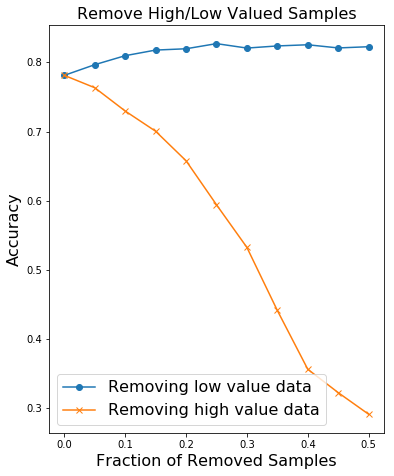

In [8]:
# Evaluates performance after removing high/low valued samples
remove_high_low_performance = remove_high_low(dve_out, eval_model, x_train, y_train, 
                                              x_valid, y_valid, x_test, y_test, 'accuracy', plot = True)

### 3. Corrupted sample discovery

For our synthetically-generated noisy training dataset, we can assess the performance of our method in **finding the noisy samples by using the known noise indices**. Note that unlike the first two evaluations, this cell is only for academic purposes because you need the ground truth noisy sample indices so if users come with their own .csv files, they cannot use this cell. 

 * Report True Positive Rates (TPR) of corrupted sample discovery.
 * Visualize the results using line graphs (set plot = True).
 * x-axis: Portions of inspected samples.
 * y-axis: True positive rates (TPR) of corrupted sample discovery.
 * Blue line: DVRL, Orange line: Optimal, Green line: Random.

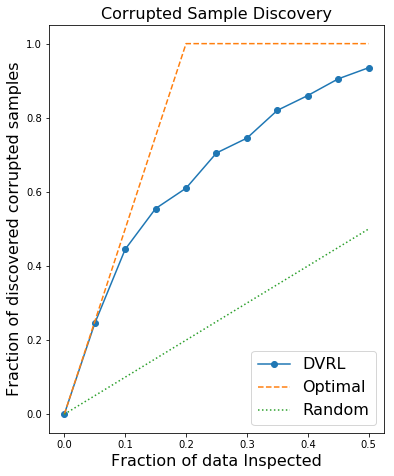

In [9]:
# If noise_rate is positive value.
if noise_rate > 0:
    
    # Evaluates true positive rates (TPR) of corrupted sample discovery and plot TPR
    noise_discovery_performance = discover_corrupted_sample(dve_out, noise_idx, noise_rate, plot = True)